<a href="https://colab.research.google.com/github/CheweeBR/Abrir-Lista-De-Chamados/blob/main/projeto_final_Tiago_Possidonio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Caminho encontrado: /content/drive/MyDrive/Colab Notebooks/Extração e Classificação/dataset
Classes encontradas em /content/drive/MyDrive/Colab Notebooks/Extração e Classificação/dataset/train : ['Dark', 'Green', 'Light', 'Medium']
Classe 'Dark': 300 imagens encontradas.
Classe 'Green': 300 imagens encontradas.
Classe 'Light': 300 imagens encontradas.
Classe 'Medium': 300 imagens encontradas.
Classes encontradas em /content/drive/MyDrive/Colab Notebooks/Extração e Classificação/dataset/test : ['Dark', 'Green', 'Light', 'Medium']
Classe 'Dark': 100 imagens encontradas.
Classe 'Green': 100 imagens encontradas.
Classe 'Light': 100 imagens encontradas.
Classe 'Medium': 100 imagens encontradas.

Shape de X_train: (1200, 512)
Shape de y_train: (1200,)
Shape de X_test: (400, 512)
Shape de y_test: (400,)
Classes (treino): ['Dark', 'Green', 'Light', 'Mediu

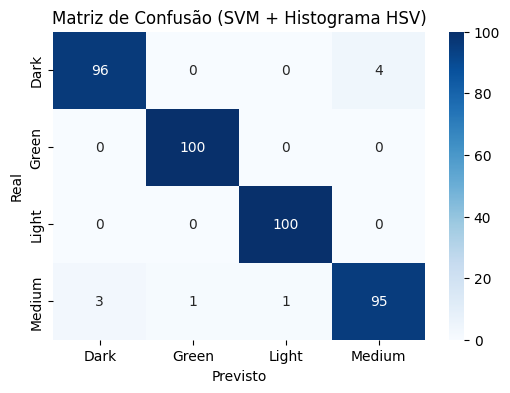

In [5]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Colab Notebooks/Extração e Classificação/dataset'

if not os.path.exists(dataset_path):
    print("Caminho não encontrado:", dataset_path)
else:
    print("Caminho encontrado:", dataset_path)

def extract_color_histogram_hsv(image, histSize=8):
    """
    Converte a imagem de BGR para HSV e extrai um histograma 3D (H, S, V) com 'histSize' bins para cada canal.
    Retorna o histograma normalizado como um vetor 1D.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h_bins = s_bins = v_bins = histSize

    hist = cv2.calcHist([hsv], [0, 1, 2], None,
                        [h_bins, s_bins, v_bins],
                        [0, 180, 0, 256, 0, 256])

    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)

    return hist.flatten()

def load_data_and_labels(folder_path):
    """
    Percorre as subpastas de 'folder_path' (cada uma representando uma classe)
    e retorna:
      X -> array com vetores de características extraídas de cada imagem
      y -> array com os rótulos (índices correspondentes às classes)
      class_names -> lista com os nomes das classes (subpastas) em ordem alfabética
    """
    X = []
    y = []
    class_names = sorted(os.listdir(folder_path))
    print("Classes encontradas em", folder_path, ":", class_names)

    for label_idx, cls_name in enumerate(class_names):
        subfolder = os.path.join(folder_path, cls_name)
        if not os.path.isdir(subfolder):
            continue

        image_files = glob.glob(os.path.join(subfolder, '*.jpg'))
        image_files += glob.glob(os.path.join(subfolder, '*.jpeg'))
        image_files += glob.glob(os.path.join(subfolder, '*.png'))
        image_files += glob.glob(os.path.join(subfolder, '*.JPG'))

        print(f"Classe '{cls_name}': {len(image_files)} imagens encontradas.")

        for img_file in image_files:
            img = cv2.imread(img_file)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                features = extract_color_histogram_hsv(img)
                X.append(features)
                y.append(label_idx)
            else:
                print("Não foi possível ler a imagem:", img_file)

    return np.array(X), np.array(y), class_names

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

X_train, y_train, train_classes = load_data_and_labels(train_dir)
X_test, y_test, test_classes = load_data_and_labels(test_dir)

print("\nShape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_test:", y_test.shape)
print("Classes (treino):", train_classes)
print("Classes (teste):", test_classes)

classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nAcurácia: {acc:.4f}\n")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=test_classes))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_classes, yticklabels=test_classes)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (SVM + Histograma HSV)")
plt.show()
